In [1]:
import os
from pathlib import Path
compe='playground-series-s3e18'
is_kaggle=os.environ.get('KAGGLE_KERNEL_RUNTYPE','')
if is_kaggle:
    path=Path(f'../input/{compe}')
    ! pip install -Uqq fastai
else:
    import kaggle,zipfile
    path=Path(f'{compe}')
    if not path.exists():
        kaggle.api.competition_download_cli(str(path))
        zipfile.ZipFile(f'{compe}.zip').extractall(path)

In [3]:
from fastai.tabular.all import *
from sklearn.metrics import roc_auc_score

pd.options.display.float_format = '{:.2f}'.format
set_seed(42)

In [4]:
df=pd.read_csv(f'{compe}/train.csv')
df_test=pd.read_csv(f'{compe}/test.csv')
df_sub=pd.read_csv(f'{compe}/sample_submission.csv')
len(df),len(df_test)

(14838, 9893)

In [5]:
print(df.shape)
df.head(3)

(14838, 38)


,id,BertzCT,Chi1,Chi1n,Chi1v,Chi2n,Chi2v,Chi3v,Chi4n,EState_VSA1,...,SlogP_VSA3,VSA_EState9,fr_COO,fr_COO2,EC1,EC2,EC3,EC4,EC5,EC6
0,0,323.39,9.88,5.88,5.88,4.30,4.30,2.75,1.75,0.00,...,4.79,35.53,0,0,1,1,0,0,0,0
1,1,273.72,7.26,4.44,5.83,3.29,4.49,2.20,1.29,45.14,...,13.83,44.71,0,0,0,1,1,0,0,0
2,2,521.64,10.91,8.53,11.05,6.67,9.52,5.82,1.77,15.65,...,17.96,45.66,0,0,1,1,0,0,1,0


In [6]:
print(df_test.shape)
df_test.head(2)

(9893, 32)


,id,BertzCT,Chi1,Chi1n,Chi1v,Chi2n,Chi2v,Chi3v,Chi4n,EState_VSA1,...,PEOE_VSA14,PEOE_VSA6,PEOE_VSA7,PEOE_VSA8,SMR_VSA10,SMR_VSA5,SlogP_VSA3,VSA_EState9,fr_COO,fr_COO2
0,14838,344.63,7.28,4.47,5.83,3.41,4.65,2.10,1.12,49.46,...,13.51,0.00,0.00,0.00,26.81,24.54,4.79,47.30,1,1
1,14839,1432.41,10.66,7.08,8.07,5.30,5.30,3.92,2.57,0.00,...,0.00,34.95,98.32,9.61,0.00,53.38,0.00,43.17,0,0


In [7]:
df_sub.head(3)

,id,EC1,EC2
0,14838,0.50,0.50
1,14839,0.50,0.50
2,14840,0.50,0.50


### EDA
> Target = EC1,EC2

In [8]:
#checking empty values
df.isna().sum().sum(),df_test.isna().sum().sum() # no empty values !!

(0, 0)

In [9]:
df.describe()

,id,BertzCT,Chi1,Chi1n,Chi1v,Chi2n,Chi2v,Chi3v,Chi4n,EState_VSA1,...,SlogP_VSA3,VSA_EState9,fr_COO,fr_COO2,EC1,EC2,EC3,EC4,EC5,EC6
count,14838.00,14838.00,14838.00,14838.00,14838.00,14838.00,14838.00,14838.00,14838.00,14838.00,...,14838.00,14838.00,14838.00,14838.00,14838.00,14838.00,14838.00,14838.00,14838.00,14838.00
mean,7418.50,515.15,9.14,5.85,6.74,4.43,5.25,3.42,1.77,29.20,...,13.64,49.31,0.46,0.46,0.67,0.80,0.31,0.28,0.14,0.15
std,4283.51,542.46,6.82,4.65,5.87,3.76,4.93,3.44,1.87,31.73,...,14.60,29.17,0.67,0.67,0.47,0.40,0.46,0.45,0.35,0.36
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,-5.43,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,3709.25,149.10,4.68,2.84,2.93,1.95,2.03,1.16,0.50,5.97,...,4.79,30.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00
50%,7418.50,290.99,6.49,4.05,4.39,2.97,3.24,1.95,1.07,17.35,...,9.59,41.67,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00
75%,11127.75,652.65,11.17,7.49,8.53,5.79,6.61,4.50,2.53,44.88,...,14.91,56.09,1.00,1.00,1.00,1.00,1.00,1.00,0.00,0.00
max,14837.00,4069.96,69.55,50.17,53.43,32.20,34.58,22.88,16.07,363.71,...,115.41,384.45,8.00,8.00,1.00,1.00,1.00,1.00,1.00,1.00


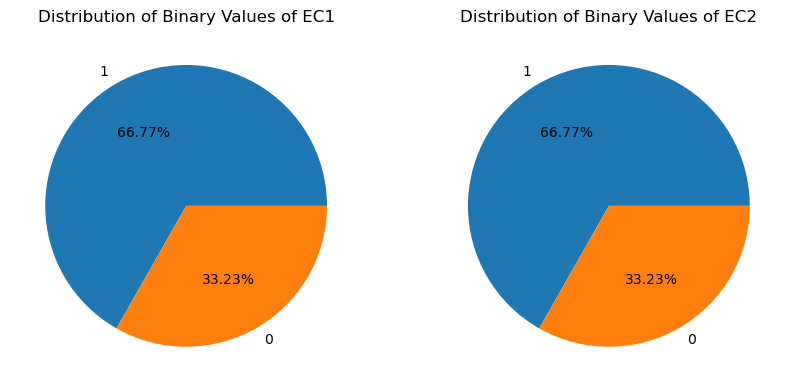

In [10]:
import matplotlib.pyplot as plt
fig,axs=plt.subplots(1,2,figsize=(10,6))
value_counts = df['EC1'].value_counts()
value_counts2 = df['EC2'].value_counts()

axs[0].pie(value_counts, labels=value_counts.index, autopct='%1.2f%%')
axs[1].pie(value_counts, labels=value_counts2.index, autopct='%1.2f%%')

axs[0].set_title('Distribution of Binary Values of EC1')
axs[1].set_title('Distribution of Binary Values of EC2')

plt.show()


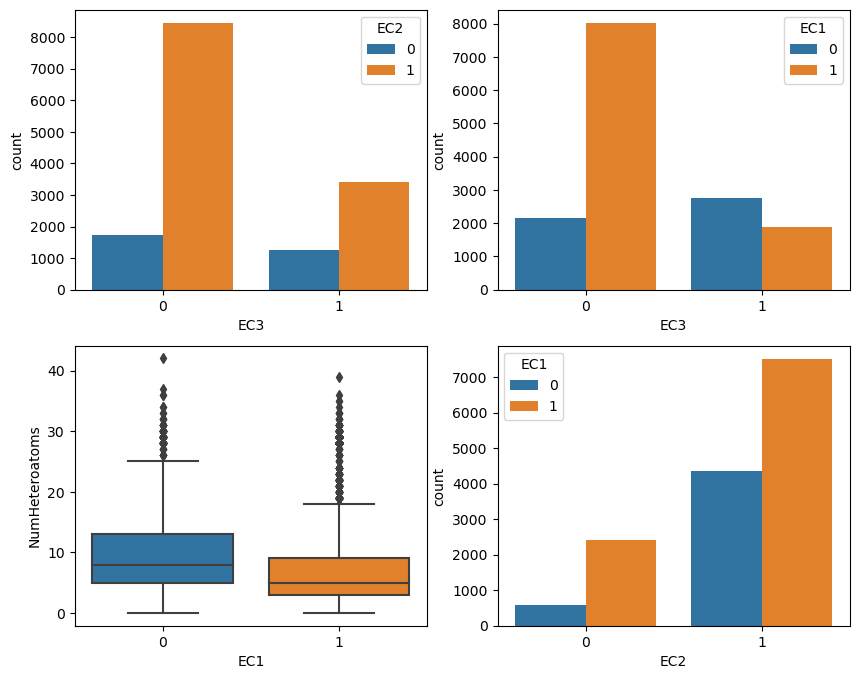

In [11]:
import seaborn as sns
fig,axs=plt.subplots(2,2,figsize=(10,8))
sns.countplot(data=df,x=df['EC2'],hue=df['EC1'],ax=axs[1][1])
sns.countplot(data=df,x=df['EC3'],hue=df['EC1'],ax=axs[0][1])
sns.countplot(data=df,x=df['EC3'],hue=df['EC2'],ax=axs[0][0])

sns.boxplot(data=df,x=df['EC1'],y=df['NumHeteroatoms'],ax=axs[1][0])
plt.show()

In [12]:
# Calculate class proportions
target_proportions = df['EC1'].value_counts() / len(df)
print(target_proportions)

1   0.67
0   0.33
Name: EC1, dtype: float64


In [13]:
# Calculate class proportions
target_proportions = df['EC2'].value_counts() / len(df)
print(target_proportions)

1   0.80
0   0.20
Name: EC2, dtype: float64


#### Feature Engineering

In [119]:
def X_Y(df1):
    X=df1.drop(['id','EC1','EC2','EC3','EC4','EC5','EC6'],axis=1)
    Y=df1['EC2']
    return X,Y
X,Y=X_Y(df.copy())

In [15]:
# def X_Y1_Y2(df1):
#     X=df1.drop(['id','EC1','EC2','EC3','EC4','EC5','EC6'],axis=1)
#     Y1=df1['EC1']
#     Y2=df1['EC2']
#     return X,Y1,Y2
# X,Y1,Y2=X_Y1_Y2(df.copy())

#### Making Building ready

In [16]:
cat_cols=[]
num_cols=X.columns.to_list()
num_cols=[x for x in num_cols if x not in cat_cols]
print(num_cols,cat_cols)

['BertzCT', 'Chi1', 'Chi1n', 'Chi1v', 'Chi2n', 'Chi2v', 'Chi3v', 'Chi4n', 'EState_VSA1', 'EState_VSA2', 'ExactMolWt', 'FpDensityMorgan1', 'FpDensityMorgan2', 'FpDensityMorgan3', 'HallKierAlpha', 'HeavyAtomMolWt', 'Kappa3', 'MaxAbsEStateIndex', 'MinEStateIndex', 'NumHeteroatoms', 'PEOE_VSA10', 'PEOE_VSA14', 'PEOE_VSA6', 'PEOE_VSA7', 'PEOE_VSA8', 'SMR_VSA10', 'SMR_VSA5', 'SlogP_VSA3', 'VSA_EState9', 'fr_COO', 'fr_COO2'] []


In [120]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [121]:
len(X_train),len(X_test)

(11870, 2968)

In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

y_train_encoded = label_encoder.fit_transform(y_train)

In [58]:
y_test_encoded=label_encoder.transform(y_test)

In [59]:
y_test_encoded

array([3, 1, 3, ..., 3, 1, 3])

In [20]:
y_train_encoded[:10]

array([3, 3, 2, 3, 3, 1, 3, 1, 3, 1])

In [21]:
print(label_encoder.classes_)

['00' '01' '10' '11']


In [22]:
# from sklearn.preprocessing import OneHotEncoder
# onehot_encoder = OneHotEncoder(sparse=False)
# y_train_reshaped = y_train.values.reshape(-1, 1)
# y_train_encoded = onehot_encoder.fit_transform(y_train_reshaped)
# y_train_encoded

In [114]:
y_test.values

array([1, 0, 1, ..., 1, 0, 1])

### Neural Nets

In [24]:
import torch
import torch.nn

In [122]:
X_tensor=torch.tensor(X_train.values).type(torch.float)
y_tensor = torch.tensor(y_train.values).type(torch.LongTensor)
X_test_tensor=torch.tensor(X_test.values).type(torch.float)
y_test_tensor = torch.tensor(y_test.values).type(torch.LongTensor)
X_tensor,y_tensor,y_test_tensor

(tensor([[1.6464e+02, 5.7364e+00, 3.3763e+00,  ..., 2.1500e+01, 0.0000e+00,
          0.0000e+00],
         [9.1284e+01, 2.6427e+00, 1.7072e+00,  ..., 1.9667e+01, 1.0000e+00,
          1.0000e+00],
         [1.6607e+03, 1.9472e+01, 1.3944e+01,  ..., 1.0823e+02, 0.0000e+00,
          0.0000e+00],
         ...,
         [3.6356e+02, 9.2730e+00, 4.2670e+00,  ..., 3.1294e+01, 0.0000e+00,
          0.0000e+00],
         [1.2649e+02, 4.7152e+00, 3.2813e+00,  ..., 3.0000e+01, 0.0000e+00,
          0.0000e+00],
         [6.9335e+01, 3.6259e+00, 1.7661e+00,  ..., 2.5333e+01, 0.0000e+00,
          0.0000e+00]]),
 tensor([1, 1, 0,  ..., 1, 1, 1]),
 tensor([1, 1, 1,  ..., 1, 1, 1]))

In [123]:
len(y_test_tensor),sum(y_test_tensor)

(2968, tensor(2400))

In [124]:
X_tensor.shape

torch.Size([11870, 31])

In [125]:
device='cpu'
NUM_FEATURES=31
NUM_CLASSES=2

In [126]:
from torch import nn

# Build model
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):

        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(), # <- does our dataset require non-linear layers? (try uncommenting and see if the results change)
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(), # <- does our dataset require non-linear layers? (try uncommenting and see if the results change)
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(), # <- does our dataset require non-linear layers? (try uncommenting and see if the results change)
            nn.Linear(in_features=hidden_units, out_features=output_features), # how many classes are there?
        )
    
    def forward(self, x):
        return self.linear_layer_stack(x)

# Create an instance of BlobModel and send it to the target device
model_4 = BlobModel(input_features=NUM_FEATURES, 
                    output_features=NUM_CLASSES, 
                    hidden_units=15).to(device)
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=31, out_features=15, bias=True)
    (1): ReLU()
    (2): Linear(in_features=15, out_features=15, bias=True)
    (3): ReLU()
    (4): Linear(in_features=15, out_features=15, bias=True)
    (5): ReLU()
    (6): Linear(in_features=15, out_features=2, bias=True)
  )
)

In [127]:
# Create loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_4.parameters(), 
                            lr=0.1) # exercise: try changing the learning rate here and seeing what happens to the model's performance

In [128]:
# Perform a single forward pass on the data (we'll need to put it to the target device for it to work)
model_4(X_tensor)[:5]

tensor([[ -1.8244,   1.8456],
        [ -0.9804,   1.0768],
        [-12.3912,  13.6101],
        [ -5.5908,   5.4754],
        [ -4.9406,   3.9795]], grad_fn=<SliceBackward0>)

In [129]:
# Make prediction logits with model
y_logits = model_4(X_tensor.to(device))

# Perform softmax calculation on logits across dimension 1 to get prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1) 
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[ -1.8244,   1.8456],
        [ -0.9804,   1.0768],
        [-12.3912,  13.6101],
        [ -5.5908,   5.4754],
        [ -4.9406,   3.9795]], grad_fn=<SliceBackward0>)
tensor([[2.4845e-02, 9.7516e-01],
        [1.1332e-01, 8.8668e-01],
        [5.1027e-12, 1.0000e+00],
        [1.5631e-05, 9.9998e-01],
        [1.3365e-04, 9.9987e-01]], grad_fn=<SliceBackward0>)


In [130]:
# Which class does the model think is *most* likely at the index 0 sample?
print(y_pred_probs[0])
print(torch.argmax(y_pred_probs[0]))

tensor([0.0248, 0.9752], grad_fn=<SelectBackward0>)
tensor(1)


In [131]:
# Fit the model
torch.manual_seed(42)

# Set number of epochs
epochs = 200

# Put data to target device
X_blob_train, y_blob_train = X_tensor.to(device), y_tensor.to(device)
X_blob_test, y_blob_test = X_test_tensor.to(device), y_test_tensor.to(device)

for epoch in range(epochs):
    ### Training
    model_4.train()

    # 1. Forward pass
    y_logits = model_4(X_blob_train) # model outputs raw logits 
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # go from logits -> prediction probabilities -> prediction labels
    # print(y_logits)
    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_blob_train) 
    acc = accuracy_fn(y_true=y_blob_train,
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_4.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model_4(X_blob_test)
      test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
      # 2. Calculate test loss and accuracy
      test_loss = loss_fn(test_logits, y_blob_test)
      test_acc = accuracy_fn(y_true=y_blob_test,
                             y_pred=test_pred)

    # Print out what's happening
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%") 

Epoch: 0 | Loss: 2.10364, Acc: 79.65% | Test Loss: 12.71535, Test Acc: 19.14%
Epoch: 10 | Loss: 0.61081, Acc: 79.65% | Test Loss: 0.59521, Test Acc: 80.86%
Epoch: 20 | Loss: 0.53975, Acc: 79.65% | Test Loss: 0.52653, Test Acc: 80.86%
Epoch: 30 | Loss: 0.51653, Acc: 79.65% | Test Loss: 0.50289, Test Acc: 80.86%
Epoch: 40 | Loss: 0.50917, Acc: 79.65% | Test Loss: 0.49464, Test Acc: 80.86%
Epoch: 50 | Loss: 0.50689, Acc: 79.65% | Test Loss: 0.49164, Test Acc: 80.86%
Epoch: 60 | Loss: 0.50619, Acc: 79.65% | Test Loss: 0.49047, Test Acc: 80.86%
Epoch: 70 | Loss: 0.50597, Acc: 79.65% | Test Loss: 0.48998, Test Acc: 80.86%
Epoch: 80 | Loss: 0.50590, Acc: 79.65% | Test Loss: 0.48975, Test Acc: 80.86%
Epoch: 90 | Loss: 0.50588, Acc: 79.65% | Test Loss: 0.48964, Test Acc: 80.86%
Epoch: 100 | Loss: 0.50587, Acc: 79.65% | Test Loss: 0.48958, Test Acc: 80.86%
Epoch: 110 | Loss: 0.50586, Acc: 79.65% | Test Loss: 0.48954, Test Acc: 80.86%
Epoch: 120 | Loss: 0.50586, Acc: 79.65% | Test Loss: 0.48952, 

In [62]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

#### Prediction

In [132]:
X_final=df_test.drop('id',axis=1)
X_final_tensor=torch.tensor(X_final.values).type(torch.float)
X_final_tensor

tensor([[3.4463e+02, 7.2836e+00, 4.4740e+00,  ..., 4.7304e+01, 1.0000e+00,
         1.0000e+00],
        [1.4324e+03, 1.0664e+01, 7.0790e+00,  ..., 4.3167e+01, 0.0000e+00,
         0.0000e+00],
        [8.3353e+01, 3.9319e+00, 1.7742e+00,  ..., 2.4667e+01, 1.0000e+00,
         1.0000e+00],
        ...,
        [3.7811e+02, 6.3103e+00, 3.4023e+00,  ..., 5.0653e+01, 0.0000e+00,
         0.0000e+00],
        [7.3765e+02, 9.9492e+00, 7.3379e+00,  ..., 5.0250e+01, 0.0000e+00,
         0.0000e+00],
        [7.8539e+02, 1.2171e+01, 7.5654e+00,  ..., 6.9131e+01, 0.0000e+00,
         0.0000e+00]])

In [133]:
with torch.inference_mode():
      # 1. Forward pass
      test_logits = model_4(X_final_tensor)
      test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
      # 2. Calculate test loss and accuracy
#       test_loss = loss_fn(test_logits, y_blob_test)
#       test_acc = accuracy_fn(y_true=y_blob_test,
#                              y_pred=test_pred)
test_pred

tensor([1, 1, 1,  ..., 1, 1, 1])

In [135]:
sum(test_pred),len(test_pred)

(tensor(9893), 9893)

In [95]:
preds_numpy=test_pred.numpy()
preds_numpy

array([3, 3, 3, ..., 3, 3, 3])

In [96]:
preds_val_nn = label_encoder.inverse_transform(preds_numpy)
preds_val_nn

array(['11', '11', '11', ..., '11', '11', '11'], dtype=object)

In [97]:
arr1_nn = np.array([x[0] for x in preds_val_nn])
arr2_nn = np.array([x[1] for x in preds_val_nn])
len(arr1_nn),len(arr2_nn)

(9893, 9893)

In [100]:
make_sub(arr1_nn, arr2_nn, sub_data=df_test, name='nn_predict')

100%|██████████| 96.6k/96.6k [00:01<00:00, 93.8kB/s]


Successfully submitted to Explore Multi-Label Classification with an Enzyme Substrate DatasetSuccessfully saved - nn_predict at Submissions/sub-nn_predict.csv


### Model Building

In [29]:
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE        



numeric_preprocessor = Pipeline(
    steps=[
        ("imputation_mean", SimpleImputer(missing_values=np.nan, strategy="mean")),
        ("scaler", StandardScaler()),
    ]
)

categorical_preprocessor = Pipeline(
    steps=[
        (
            "imputation_constant",
            SimpleImputer(fill_value="missing", strategy="most_frequent"),
        ),
        ("onehot", OneHotEncoder(handle_unknown="ignore")),
    ]
)

preprocessor = ColumnTransformer(
    [
        ("categorical", categorical_preprocessor, cat_cols),
        ("numerical", numeric_preprocessor,num_cols),
    ]
)

pipe = make_pipeline(preprocessor, XGBClassifier())
pipe  # click on the diagram below to see the details of each step

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('imputation_constant',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  []),
                                                 ('numerical',
                                                  Pipeline(steps=[('imputation_mean',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['BertzCT', 'Ch...
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=None, ...))])

In [30]:
(X_train.head(2))

,BertzCT,Chi1,Chi1n,Chi1v,Chi2n,Chi2v,Chi3v,Chi4n,EState_VSA1,EState_VSA2,...,PEOE_VSA14,PEOE_VSA6,PEOE_VSA7,PEOE_VSA8,SMR_VSA10,SMR_VSA5,SlogP_VSA3,VSA_EState9,fr_COO,fr_COO2
36,164.64,5.74,3.38,3.38,2.21,2.21,1.37,0.60,0.00,17.92,...,0.00,12.14,17.70,0.00,6.29,0.00,0.00,21.50,0,0
9482,91.28,2.64,1.71,1.71,0.93,0.93,0.40,0.00,5.97,12.32,...,5.97,0.00,0.00,6.04,12.32,0.00,9.59,19.67,1,1


#### XGB Classifier

In [31]:
pipe.fit(X_train,y_train_encoded)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('imputation_constant',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  []),
                                                 ('numerical',
                                                  Pipeline(steps=[('imputation_mean',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['BertzCT', 'Ch...
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               objective='multi:softprob', predictor=None, ...))])

In [32]:
preds_encoded=pipe.predict(X_test)
preds_encoded

array([3, 3, 3, ..., 3, 1, 3])

In [33]:
# y_pred = preds_encoded.apply(lambda x: label_encoder.inverse_transform(x))
y_pred = label_encoder.inverse_transform(preds_encoded)
y_pred

array(['11', '11', '11', ..., '11', '01', '11'], dtype=object)

In [34]:
arr1 = np.array([x[0] for x in y_pred])
arr2 = np.array([x[1] for x in y_pred])
len(arr1),len(X_test)

(2968, 2968)

In [37]:
evaluation(y_test,preds_encoded,label_encoder)

0.564031639430036

### Predicting values for Test df

In [38]:
df_test.head(2)

,id,BertzCT,Chi1,Chi1n,Chi1v,Chi2n,Chi2v,Chi3v,Chi4n,EState_VSA1,...,PEOE_VSA14,PEOE_VSA6,PEOE_VSA7,PEOE_VSA8,SMR_VSA10,SMR_VSA5,SlogP_VSA3,VSA_EState9,fr_COO,fr_COO2
0,14838,344.63,7.28,4.47,5.83,3.41,4.65,2.10,1.12,49.46,...,13.51,0.00,0.00,0.00,26.81,24.54,4.79,47.30,1,1
1,14839,1432.41,10.66,7.08,8.07,5.30,5.30,3.92,2.57,0.00,...,0.00,34.95,98.32,9.61,0.00,53.38,0.00,43.17,0,0


In [39]:
X_test_final=df_test.drop('id',axis=1)
X_test_final.head(2)

,BertzCT,Chi1,Chi1n,Chi1v,Chi2n,Chi2v,Chi3v,Chi4n,EState_VSA1,EState_VSA2,...,PEOE_VSA14,PEOE_VSA6,PEOE_VSA7,PEOE_VSA8,SMR_VSA10,SMR_VSA5,SlogP_VSA3,VSA_EState9,fr_COO,fr_COO2
0,344.63,7.28,4.47,5.83,3.41,4.65,2.10,1.12,49.46,0.00,...,13.51,0.00,0.00,0.00,26.81,24.54,4.79,47.30,1,1
1,1432.41,10.66,7.08,8.07,5.30,5.30,3.92,2.57,0.00,29.78,...,0.00,34.95,98.32,9.61,0.00,53.38,0.00,43.17,0,0


In [40]:
preds_test=pipe.predict(X_test_final)
preds_test

array([1, 3, 3, ..., 1, 1, 1])

In [41]:
y_pred_test = label_encoder.inverse_transform(preds_test)
y_pred_test

array(['01', '11', '11', ..., '01', '01', '01'], dtype=object)

In [42]:
preds_test_1 = np.array([x[0] for x in y_pred_test])
preds_test_2 = np.array([x[1] for x in y_pred_test])
len(preds_test_1),len(preds_test_2)

(9893, 9893)

In [77]:
pipe.fit(X,Y2)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('imputation_constant',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='most_frequent'))]),
                                                  []),
                                                 ('numerical',
                                                  Pipeline(steps=[('imputation_mean',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['BertzCT', 'Chi1', 'Chi1n',
                                                   'Chi1v', 'Chi2n', 'Chi2v',
                                                   'Chi3v', 'Chi4n...
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=None, ...))])

In [81]:
preds2=pipe.predict(X_test)
preds2

array([1, 1, 1, ..., 1, 1, 1])

In [82]:
preds2[:20]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

### Random Forest Classifier

In [46]:
X_train.shape,y_train_encoded.shape

((11870, 31), (11870,))

In [155]:
X.head(2)

,BertzCT,Chi1,Chi1n,Chi1v,Chi2n,Chi2v,Chi3v,Chi4n,EState_VSA1,EState_VSA2,...,PEOE_VSA6,PEOE_VSA7,PEOE_VSA8,SMR_VSA10,SMR_VSA5,SlogP_VSA3,VSA_EState9,fr_COO,fr_COO2,EC1
0,323.39,9.88,5.88,5.88,4.30,4.30,2.75,1.75,0.00,11.94,...,0.00,0.00,0.00,17.74,0.00,4.79,35.53,0,0,1
1,273.72,7.26,4.44,5.83,3.29,4.49,2.20,1.29,45.14,0.00,...,0.00,0.00,0.00,7.82,30.71,13.83,44.71,0,0,0


In [47]:
from imblearn.pipeline import make_pipeline as make_imb_pipeline
pipe_rf=make_imb_pipeline(SMOTE(random_state=42),preprocessor,RandomForestClassifier())
pipe_rf

Pipeline(steps=[('smote', SMOTE(random_state=42)),
                ('columntransformer',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('imputation_constant',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  []),
                                                 ('numerical',
                                                  Pipeline(steps=[('imputation_mean',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   S...
                                                   'EState_VSA1', 'EState_VSA2',
                                                   'ExactMolWt',
                                                   'FpDensityMorgan1',
                                                   'FpDensityMorgan2',
                                                   'FpDensityMorgan3',
                                                   'HallKierAlpha',
                                                   'HeavyAtomMolWt', 'Kappa3',
                                                   'MaxAbsEStateIndex',
                                                   'MinEStateIndex',
                                                   'NumHeteroatoms',
                                                   'PEOE_VSA10', 'PEOE_VSA14',
                                                   'PEOE_VSA6', 'PEOE_VSA7',
                                                   'PEOE_VSA8', 'SMR_VSA10',
                                                   'SMR_VSA5', 'SlogP_VSA3',
                                                   'VSA_EState9', 'fr_COO', ...])])),
                ('randomforestclassifier', RandomForestClassifier())])

In [48]:
pipe_rf.fit(X_train,y_train_encoded)

Pipeline(steps=[('smote', SMOTE(random_state=42)),
                ('columntransformer',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('imputation_constant',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  []),
                                                 ('numerical',
                                                  Pipeline(steps=[('imputation_mean',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   S...
                                                   'EState_VSA1', 'EState_VSA2',
                                                   'ExactMolWt',
                                                   'FpDensityMorgan1',
                                                   'FpDensityMorgan2',
                                                   'FpDensityMorgan3',
                                                   'HallKierAlpha',
                                                   'HeavyAtomMolWt', 'Kappa3',
                                                   'MaxAbsEStateIndex',
                                                   'MinEStateIndex',
                                                   'NumHeteroatoms',
                                                   'PEOE_VSA10', 'PEOE_VSA14',
                                                   'PEOE_VSA6', 'PEOE_VSA7',
                                                   'PEOE_VSA8', 'SMR_VSA10',
                                                   'SMR_VSA5', 'SlogP_VSA3',
                                                   'VSA_EState9', 'fr_COO', ...])])),
                ('randomforestclassifier', RandomForestClassifier())])

In [54]:
preds_val_rf=pipe_rf.predict(X_test)
preds_val_rf

array([3, 1, 3, ..., 2, 1, 3])

In [51]:
preds_val_rf = label_encoder.inverse_transform(preds_val_rf)
preds_val_rf

array(['11', '01', '11', ..., '10', '01', '11'], dtype=object)

In [52]:
preds_val_rf = label_encoder.inverse_transform(preds_val_rf)
arr1_rf = np.array([x[0] for x in preds_val_rf])
arr2_rf = np.array([x[1] for x in preds_val_rf])
len(arr1_rf),len(arr2_rf)

(2968, 2968)

In [55]:
evaluation(y_test,preds_val_rf,label_encoder)

0.5759555959348824

#### Logistic Regression

In [56]:
from sklearn.linear_model import LogisticRegression
pipe_lr=make_pipeline(preprocessor,LogisticRegression())

In [139]:
X.shape,X_test.shape

((14838, 32), (9893, 32))

In [57]:
pipe_lr.fit(X_train,y_train_encoded)

/Volumes/TAPPS/DS_APPS/anaconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('imputation_constant',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  []),
                                                 ('numerical',
                                                  Pipeline(steps=[('imputation_mean',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['BertzCT', 'Ch...
                                                   'EState_VSA1', 'EState_VSA2',
                                                   'ExactMolWt',
                                                   'FpDensityMorgan1',
                                                   'FpDensityMorgan2',
                                                   'FpDensityMorgan3',
                                                   'HallKierAlpha',
                                                   'HeavyAtomMolWt', 'Kappa3',
                                                   'MaxAbsEStateIndex',
                                                   'MinEStateIndex',
                                                   'NumHeteroatoms',
                                                   'PEOE_VSA10', 'PEOE_VSA14',
                                                   'PEOE_VSA6', 'PEOE_VSA7',
                                                   'PEOE_VSA8', 'SMR_VSA10',
                                                   'SMR_VSA5', 'SlogP_VSA3',
                                                   'VSA_EState9', 'fr_COO', ...])])),
                ('logisticregression', LogisticRegression())])

In [58]:
preds_lr_encoded=pipe_lr.predict(X_test)
preds_lr_encoded

array([3, 1, 3, ..., 3, 1, 3])

In [59]:
evaluation(y_test,preds_lr_encoded,label_encoder)

0.5565617799065112

### Model Analysis

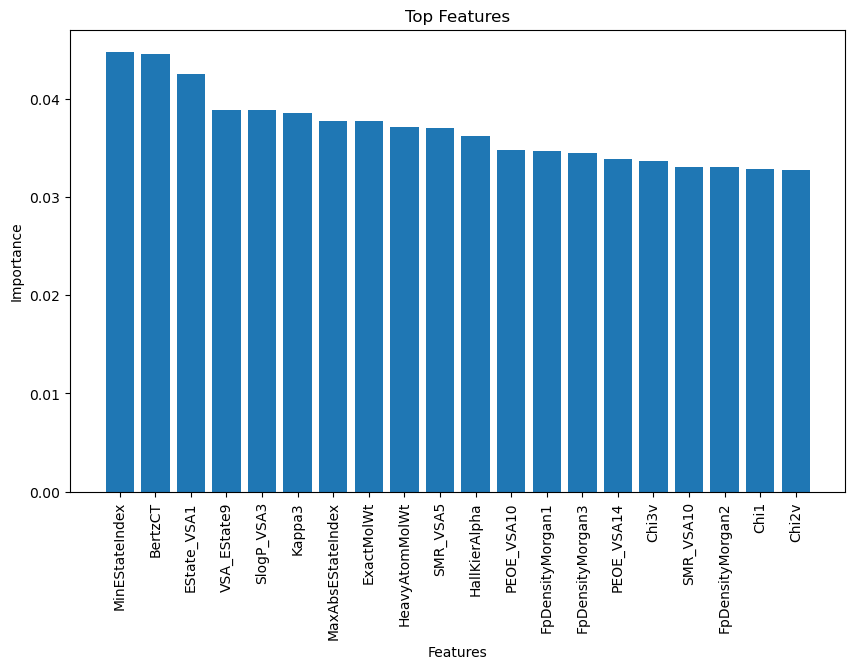

In [62]:
model_imp(pipe_rf)

In [60]:
def model_imp(pipe_obj):
    model_name = pipe_obj.steps[-1][0]
    model = pipe_obj.named_steps[model_name]
    importances = model.feature_importances_
    importances
    feature_names = X.columns
    feature_importances = sorted(zip(importances, feature_names), reverse=True)
    k=20
    top_features = feature_importances[:k]
    features = [feature for importance, feature in top_features]
    importance_values = [importance for importance, feature in top_features]
    plt.figure(figsize=(10, 6))
    plt.bar(features, importance_values)
    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.title('Top Features')
    plt.xticks(rotation=90)
    plt.show()

#### Testing the values

In [ ]:
arr1 = np.array([x[0] for x in y_pred])
arr2 = np.array([x[1] for x in y_pred])
len(arr1),len(X_test)

In [74]:
y_true=df[['EC1','EC2']]
y_true

,EC1,EC2
0,1,1
1,0,1
2,1,1
3,1,1
4,1,0
...,...,...
14833,1,1
14834,0,1
14835,1,1
14836,0,1


In [87]:
# y_test1=y_test.to_frame(name='EC')
# y_test
# y_true[['EC1', 'EC2']] = y_test['EC'].str.split('', expand=True)
# y_true.columns
len(y_true)

14838

In [98]:
y_test[['EC1', 'EC2']] = y_test['EC'].str.split('', expand=True).iloc[:, 1:3]
# y_test[['EC1', 'EC2']]
y_test1=y_test.drop('EC',axis=1)
y_test1

,EC1,EC2
11988,1,1
13039,0,1
13637,1,1
5537,0,0
8425,1,1
...,...,...
1201,1,1
2727,1,1
5987,1,1
7656,0,1


In [36]:
def evaluation(y_true_series,y_preds_encoded,label_encoder=label_encoder):
    y_pred = label_encoder.inverse_transform(y_preds_encoded)
    arr1 = np.array([x[0] for x in y_pred])
    arr2 = np.array([x[1] for x in y_pred])
    y_pred = pd.DataFrame({'EC1': arr1,
                           'EC2':arr2})
    y_true_labeled=y_true_series.to_frame(name='EC')
    y_true_labeled[['EC1', 'EC2']] = y_true_labeled['EC'].str.split('', expand=True).iloc[:, 1:3]
    y_test1=y_true_labeled.drop('EC',axis=1)
    auc_scores = []
    for column in y_pred.columns:
        auc = roc_auc_score(y_test1[column], y_pred[column])
        auc_scores.append(auc)
    average_auc = sum(auc_scores) / len(auc_scores)
    return average_auc

In [101]:
average_auc

0.564031639430036

### Submission

In [70]:
df_sub.head(2)

,id,EC1,EC2
0,14838,0.50,0.50
1,14839,0.50,0.50


In [44]:
import subprocess
def make_sub(pred_y1,pred_y2,sub_data=df_test,name='default'):
    df_submission = pd.DataFrame()
    df_submission['id']=df_test['id']
    df_submission['EC1']=pred_y1
    df_submission['EC2']=pred_y2
    df_submission.to_csv(f'submission-{name}.csv', index=False)
    cmd =f'kaggle competitions submit -c {compe} -f submission-{name}.csv -m "Message"'
    subprocess.run(cmd, shell=True)
    print(f'succesully saved - {name}')


In [98]:
import subprocess
import os

def make_sub(pred_y1, pred_y2, sub_data=df_test, name='default'):
    df_submission = pd.DataFrame()
    df_submission['id'] = df_test['id']
    df_submission['EC1'] = pred_y1
    df_submission['EC2'] = pred_y2
    
    folder_path = 'Submissions/'
    os.makedirs(folder_path, exist_ok=True)  # Create the folder if it doesn't exist
    
    file_path = os.path.join(folder_path, f'sub-{name}.csv')
    df_submission.to_csv(file_path, index=False)
    
    cmd = f'kaggle competitions submit -c {compe} -f {file_path} -m "Message"'
    subprocess.run(cmd, shell=True)
    
    print(f'Successfully saved - {name} at {file_path}')


In [78]:
preds1=np.full(len(df_test),0.67)
preds2=np.full(len(df_test),0.80)

In [97]:
make_sub(preds1,preds2,name='rf_Pipe')

100%|██████████| 96.6k/96.6k [00:01<00:00, 97.1kB/s]


Successfully submitted to Explore Multi-Label Classification with an Enzyme Substrate Datasetsuccesully saved - rf_Pipe


In [ ]:
len(preds_test_1),len(preds_test_2)

In [45]:
make_sub(preds_test_1,preds_test_2,name='multi_class')

100%|██████████| 96.6k/96.6k [00:00<00:00, 111kB/s] 


Successfully submitted to Explore Multi-Label Classification with an Enzyme Substrate Datasetsuccesully saved - multi_class
